In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
from sqlalchemy import inspect


In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# Use the Base class to reflect the database tables
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# look at tables using the inspector to print the column names within each table and its types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# look at tables using the inspector to print the column names within each table and its types
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Last Data point in database
lst_dt= session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
lst_dt= datetime.strptime(lst_dt, "%Y-%m-%d")
lst_dt

datetime.datetime(2017, 8, 23, 0, 0)

In [13]:
#timedelta for one year prior to last date, 366 instead of 365 days in order to include start date itself in query.
strt_dt= lst_dt -timedelta(days=365)
strt_dt

datetime.datetime(2016, 8, 23, 0, 0)

In [14]:
# Perform a query to retrieve the date and precipitation scores
prcp_date = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date>=strt_dt).order_by(Measurement.date).all()
prcp_date                

                          



[(0.08, '2016-08-24'),
 (2.15, '2016-08-24'),
 (2.28, '2016-08-24'),
 (None, '2016-08-24'),
 (1.22, '2016-08-24'),
 (2.15, '2016-08-24'),
 (1.45, '2016-08-24'),
 (0.08, '2016-08-25'),
 (0.08, '2016-08-25'),
 (0.0, '2016-08-25'),
 (0.0, '2016-08-25'),
 (0.21, '2016-08-25'),
 (0.06, '2016-08-25'),
 (0.11, '2016-08-25'),
 (0.0, '2016-08-26'),
 (0.03, '2016-08-26'),
 (0.02, '2016-08-26'),
 (0.04, '2016-08-26'),
 (0.0, '2016-08-26'),
 (0.01, '2016-08-26'),
 (0.0, '2016-08-27'),
 (0.18, '2016-08-27'),
 (0.02, '2016-08-27'),
 (0.0, '2016-08-27'),
 (0.12, '2016-08-27'),
 (None, '2016-08-27'),
 (0.01, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.14, '2016-08-28'),
 (0.6, '2016-08-28'),
 (2.07, '2016-08-28'),
 (0.0, '2016-08-29'),
 (0.17, '2016-08-29'),
 (0.04, '2016-08-29'),
 (None, '2016-08-29'),
 (0.0, '2016-08-29'),
 (0.35, '2016-08-29'),
 (0.9, '2016-08-29'),
 (0.0, '2016-08-30'),
 (0.0, '2016-08-30'),
 (0.02, '2016-08-30'),
 (0.0, '2016-08-30'),
 (0.0, '2016-08-30'),
 (

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_date, columns=['Precipitation', 'Dates'])
df["Dates"]=pd.to_datetime(df["Dates"])
df.set_index(['Dates'], inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)
df2=df.dropna()
print(df2)

            Precipitation
Dates                    
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           1.22
2016-08-24           2.15
...                   ...
2017-08-22           0.50
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45

[2015 rows x 1 columns]


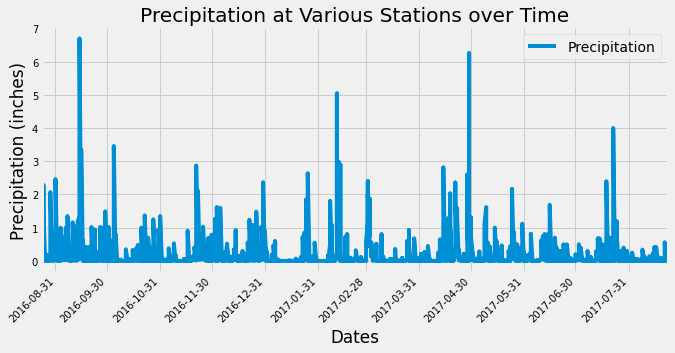

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
dates = pd.date_range(start=pd.to_datetime('2016-08-23'), end=pd.to_datetime('2017-08-23'), freq='M')

ax=df2.plot(figsize=(10,5), xticks= dates, fontsize=10, rot=45)

ax.set(ylabel="Precipitation (inches)",
       title="Precipitation at Various Stations over Time")

# ax.set_xticklabels(x_labels, rot=45)
ax.set_xlim(pd.to_datetime('2016-08-23'), pd.to_datetime('2017-08-23'))

plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sts= df2['Precipitation'].describe()
sts

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [18]:
# Design a query to show how many stations are available in this dataset?
nm_stn = session.query(Station.station).count()
nm_stn

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]

stn_ct=session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stn_ct



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
mst_actv_stn=stn_ct[0][0]
print(f' the most active station is: {mst_actv_stn}')

min_tmp=session.query(func.min(Measurement.tobs)).filter(Measurement.station==mst_actv_stn).first()[0]
print(f' The min temp of this station is: {min_tmp}')

max_tmp=session.query(func.max(Measurement.tobs)).filter(Measurement.station==mst_actv_stn).first()[0]
print(f' The max temp of this station is: {max_tmp}')

avg_tmp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==mst_actv_stn).first()[0]
avg_tmp=round(avg_tmp,1)
print(f' The average temp of this station is: {avg_tmp}')


 the most active station is: USC00519281
 The min temp of this station is: 54.0
 The max temp of this station is: 85.0
 The average temp of this station is: 71.7


In [21]:
# Choose the station with the highest number of temperature observations in the last 12 months.
sel = [Measurement.station, func.count(Measurement.tobs)]
num_obs=func.count(Measurement.tobs)
tmp_obs_rank=session.query(*sel).filter(Measurement.date>=strt_dt).group_by(Measurement.station).order_by(num_obs.desc()).all()

tmp_obs_rank




[('USC00519397', 360),
 ('USC00519281', 351),
 ('USC00516128', 348),
 ('USC00513117', 342),
 ('USC00519523', 336),
 ('USC00514830', 304),
 ('USC00517948', 182)]

In [22]:
most_tmp_obs=tmp_obs_rank[0][0]
print(f' The station with the most temperature observations is {most_tmp_obs}.')

 The station with the most temperature observations is USC00519397.


In [23]:
# Query the last 12 months of temperature observation data for the overall most active station and plot the results as a histogram:
yr_tmp=session.query(Measurement.tobs).filter(Measurement.station==mst_actv_stn).filter(Measurement.date>=strt_dt).all()
tmp2plt=pd.DataFrame(yr_tmp)
tmp2plt



,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


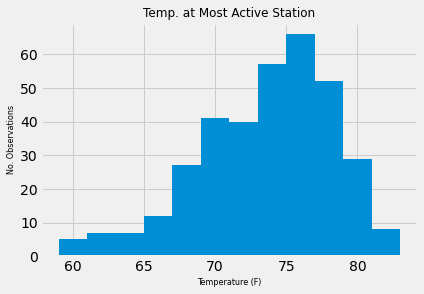

In [24]:
#plot histogram of data:
ax= plt.hist(tmp2plt['tobs'], bins =12)
plt.title(f'Temp. at Most Active Station', fontsize= 12)
plt.xlabel('Temperature (F)', fontsize= 8)
plt.ylabel('No. Observations', fontsize=8)
plt.show()

## Bonus Challenge Assignment

BONUS PART 1:Temperature Analysis I

In [25]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
date_str = '06'
June=session.query(func.avg(Measurement.tobs)).filter(func.strftime('%m',Measurement.date)==date_str).all()[0][0]
JuneT=round(June,1)
print(f' The average temperature in Jun is: {JuneT} F')

 The average temperature in Jun is: 74.9 F


In [26]:
# Do the same for December temperature.
date_str = '12'
Dec=session.query(func.avg(Measurement.tobs)).filter(func.strftime('%m',Measurement.date)==date_str).all()[0][0]
DecT=round(Dec,1)
print(f' The average temperature in Dec is: {DecT} F')

 The average temperature in Dec is: 71.0 F


BONUS PART 2:Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_tmp=(calc_temps('2011-02-28', '2011-03-05'))
print(f'From 02/28/2011 - 03/05/2011: The min temp was {trip_tmp[0][0]}F,')
print(f'the average temp was {round(trip_tmp[0][1],1)}F, and the max temp was {trip_tmp[0][2]}F.')


From 02/28/2011 - 03/05/2011: The min temp was 61.0F,
the average temp was 69.8F, and the max temp was 75.0F.


<function matplotlib.pyplot.show(*args, **kw)>

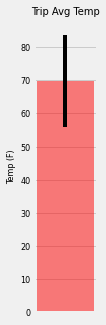

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error_val= trip_tmp[0][2]-trip_tmp[0][0]
plt.figure(figsize=(1,5))
ax =plt.bar(x=0, height=trip_tmp[0][1], yerr=error_val, color='red', alpha =.5)
plt.title('Trip Avg Temp', fontsize = 10)
plt.ylabel('Temp (F)', fontsize=8)
plt.yticks(fontsize=8)

plt.xticks([])

plt.show

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date='2011-02-28'
end_date='2011-03-05'
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
yr_rain=session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
st_rain=pd.DataFrame(data=yr_rain, columns= ['Station', 'Total_Rainfall', 'Station_Name', 'Latitude','Longitude', 'Elevation'])
st_rain

,Station,Total_Rainfall,Station_Name,Latitude,Longitude,Elevation
0,USC00518838,2.33,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
1,USC00519281,2.23,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00519523,2.19,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,1.96,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00516128,1.45,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,USC00513117,1.44,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,USC00519397,1.38,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,USC00511918,0.63,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip --see prior start_date and end_date

# Use the start and end date to create a range of dates
date_list=pd.date_range(start=start_date, end=end_date, freq='D')
date_list



DatetimeIndex(['2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03',
               '2011-03-04', '2011-03-05'],
              dtype='datetime64[ns]', freq='D')

In [33]:
# Strip off the year and save a list of %m-%d strings
dates=date_list.strftime('%m-%d')
dates

Index(['02-28', '03-01', '03-02', '03-03', '03-04', '03-05'], dtype='object')

In [34]:
# Loop through the list of %m-%d strings and calculate the normals for each date
Trip_Normals=[]
for date in dates:
    Trip_Normals.append(list(np.ravel(daily_normals(date))))
Trip_Normals

[[65.0, 70.65517241379311, 80.0],
 [64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0]]

In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
MinT= []
AvgT=[]
MaxT=[]

for data_list in Trip_Normals:
    MinT.append(data_list[0])
    AvgT.append(round(data_list[1],1))
    MaxT.append(data_list[2])
df= pd.DataFrame()
df['date']=dates
df['Min_Temp']=MinT
df['Avg_Temp']=(AvgT)
df['Max_Temp']=MaxT
df=df.set_index('date')
df

,Min_Temp,Avg_Temp,Max_Temp
date,,,
02-28,65.0,70.7,80.0
03-01,64.0,70.0,76.0
03-02,61.0,70.4,78.0
03-03,60.0,70.1,78.0
03-04,57.0,69.3,77.0
03-05,60.0,67.9,76.0


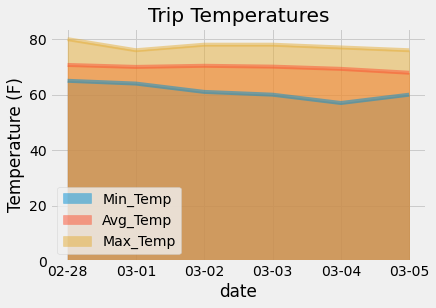

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, alpha=.5, title='Trip Temperatures')
plt.ylabel('Temperature (F)')
plt.show()
